In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import os
import timm
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold


from datamodule import RSNAdataset
from config import config
from gradcam import GradCAM

c:\Users\KaranjotVendal\mambaforge\envs\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\KaranjotVendal\mambaforge\envs\thesis\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\KaranjotVendal\mambaforge\envs\thesis\L

In [2]:
class ConvxLSTM(nn.Module):
    '''ConvNext: pretrained IMAGENET, not trainable
        LSTM: 1 layer, 64 units, unidirectional
        FC: 32 units
        classifier: 2 units'''
    def __init__(self, num_classes):
        super().__init__()
        
        self.cnn = timm.create_model('convnextv2_tiny.fcmae_ft_in22k_in1k', pretrained=True, num_classes=0, in_chans=1)
        if config.USE_ft_convnext:
            checkpoint = torch.load(f'./data/pretrain_convnext/ConvNext_finetuned_model_best_auroc.pth')
            self.cnn.load_state_dict(checkpoint["model_state_dict"], strict=False)
        for param in self.cnn.parameters():
            param.requires_grad = True
        in_features = self.cnn(torch.randn(2, 1, config.IMG_SIZE, config.IMG_SIZE)).shape[1]
        
        self.rnn = nn.LSTM(input_size=in_features, hidden_size=config.RNN, batch_first= True, bidirectional=False)
        
        self.fc = nn.Linear(config.N_SLICES * config.RNN, config.FC, bias=True)
        self.classifier = nn.Linear(config.FC, num_classes, bias=True)        
        
    def forward(self, x, org):
        # x shape: BxSxCxHxW
        batch_size, slices, C, H, W = x.size()
        c_in = x.view(batch_size * slices, C, H, W)
    
        out = self.cnn(c_in)
        rnn_in = out.view(batch_size, slices, -1)
        out, hd = self.rnn(rnn_in)
        mask = self.mask_layer(org)
        out = out * mask
        batch, slices, rnn_features = out.size()
        out = out.reshape(batch, slices * rnn_features)
        out = F.relu(self.fc(out))
        logits = self.classifier(out)
        output = F.softmax(logits, dim=1)
        
        return logits, output

    def mask_layer(self, org):
        masks = []
        org = org[0].cpu().numpy()
        for i in org:
            dup = config.N_SLICES - i
            mask_1 = torch.ones(i, config.RNN) # .to(device='cuda')
            mask_0 = torch.zeros(dup, config.RNN) #.to(device='cuda')
            mask = torch.cat((mask_1, mask_0), 0)
            masks.append(mask)

        masks = torch.stack(masks).to(config.DEVICE)
        return masks

In [3]:
model = ConvxLSTM(config.NUM_CLASSES)
checkpoint = torch.load(f'.\experiments2.0\experiment 3\weights\ConvxLSTM_model_FLAIR_3.pth')
model.load_state_dict(checkpoint["model_state_dict"])
model.to(config.DEVICE)

ConvxLSTM(
  (cnn): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
     

In [4]:
target_layer = model.cnn.stages[3].blocks[2].conv_dw
target_layer

Conv2d(768, 768, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=768)

In [5]:
dlt = []
empty_fld = [109, 123, 709]
df = pd.read_csv("data/train_labels.csv")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
X = df['BraTS21ID'].values
Y = df['MGMT_value'].values

for i in empty_fld:
    j = np.where(X == i)
    dlt.append(j)
    X = np.delete(X, j)
    
Y = np.delete(Y,dlt)

In [6]:
for fold, (train_idx, test_idx) in enumerate(skf.split(np.zeros(len(Y)), Y), 1):  

    xtrain = X[train_idx]
    ytrain = Y[train_idx]
    xtest = X[test_idx]
    ytest = Y[test_idx]

    train_set = RSNAdataset(
                    config.DATA_PATH,
                    xtrain,  
                    ytrain,
                    n_slices=config.N_SLICES,
                    img_size=config.IMG_SIZE,
                    type = config.MOD,
                    transform=None
                        )

    test_set = RSNAdataset(
                    config.DATA_PATH,
                    xtest,  
                    ytest,
                    n_slices=config.N_SLICES,
                    img_size=config.IMG_SIZE,
                    type = config.MOD,
                    transform=None
                        )
    
    train_loader = DataLoader(
                train_set,    
                batch_size=1,
                shuffle=True,
                num_workers=config.NUM_WORKERS,
            )
    
    test_loader = DataLoader(
                test_set,    
                batch_size=1,
                shuffle=False,
                num_workers=config.NUM_WORKERS,
            )
    
    break

In [ ]:
train_set = RSNAdataset(
                config.DATA_PATH,
                X,  
                Y,
                n_slices=config.N_SLICES,
                img_size=config.IMG_SIZE,
                type = config.MOD,
                transform=None
                )

train_loader = DataLoader(
                train_set,    
                batch_size=1,
                shuffle=False,
                num_workers=config.NUM_WORKERS,
            )    

In [7]:
for batch in train_loader:  
    print('Image batch dimensions:', batch['X'].shape)
    print('Image Class dimensions:', batch['y'].shape)
    print('Image original slices', batch['org'])
    train_image = batch['X']
    train_org = batch['org']
    break

for batch in test_loader:  
    print('Image batch dimensions:', batch['X'].shape)
    print('Image Class dimensions:', batch['y'].shape)
    print('Image original slices', batch['org'])
    test_image = batch['X']
    test_org = batch['org']
    break

Image batch dimensions: torch.Size([1, 250, 1, 112, 112])
Image Class dimensions: torch.Size([1])
Image original slices [tensor([35])]
Image batch dimensions: torch.Size([1, 250, 1, 112, 112])
Image Class dimensions: torch.Size([1])
Image original slices [tensor([202])]


Training heatmaps

In [8]:
cam = GradCAM(model, target_layer)

In [9]:
heatmap, images = cam.compute_cam(train_image, train_org)

Forward hook running...
Activations size: torch.Size([250, 768, 3, 3])
prediction: tensor([0], device='cuda:0')
Backward hook running...
Gradients size: torch.Size([250, 768, 3, 3])


In [ ]:
heatmap.shape

In [ ]:
images.shape

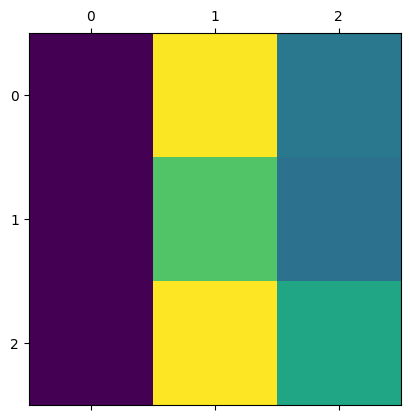

In [10]:
plt.matshow(heatmap[1, :, :])
plt.show()

In [11]:
def get_resized_heatmap(heatmap, shape):
    """Resize heatmap to shape: batch_size, slices, C, H, W"""
    # Given the provided shape, we're interested in resizing based on the slices, H, and W dimensions.
    
    # Rescale heatmap to a range 0-255
    upscaled_heatmap = np.uint8(255 * heatmap)
    print(upscaled_heatmap.shape)
    print(shape)

    # Calculate zoom factors for each dimension
    upscaled_heatmap = zoom(
        upscaled_heatmap,
        (
            shape[0] / upscaled_heatmap.shape[0],  # slices dimension
            shape[2] / upscaled_heatmap.shape[1],  # H dimension
            shape[3] / upscaled_heatmap.shape[2],  # W dimension
        ),
    )

    return upscaled_heatmap

In [12]:
resized_heatmap = get_resized_heatmap(heatmap, images.shape)

(250, 3, 3)
(250, 1, 112, 112)


In [ ]:
resized_heatmap.shape

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(2, 2))
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)


# Assuming batch size is 1 for simplicity. If batch size > 1, you can change the index to visualize other samples.
slice_idx = 60  # The slice number you want to visualize
image = images[slice_idx]
image = image.squeeze(0)

# Display the original slice on the left
ax[0].imshow(image, cmap='bone')

# Display the original slice on the right
img0 = ax[1].imshow(image, cmap='bone')

# Overlay the heatmap on the right image
img1 = ax[1].imshow(resized_heatmap[slice_idx, :, :], cmap='jet', alpha=0.3, extent=img0.get_extent())

plt.tight_layout()
plt.savefig(f'./gradcam_img{1}.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.close()

In [25]:
if not os.path.exists('./plots'):
    os.mkdir(base_dir)
if not os.path.exists('./plots/GradCAM/'):
    os.mkdir('./plots/GradCAM')
if not os.path.exists('./plots/GradCAM/train/'):
    os.mkdir('./plots/GradCAM/train')    

for i in range(train_org[0]):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(2, 2))
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)

    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)


    # Assuming batch size is 1 for simplicity. If batch size > 1, you can change the index to visualize other samples.
    slice_idx = i  # The slice number you want to visualize
    image = images[slice_idx]
    image = image.squeeze(0)

    # Display the original slice on the left
    ax[0].imshow(image, cmap='bone')

    # Display the original slice on the right
    img0 = ax[1].imshow(image, cmap='bone')

    # Overlay the heatmap on the right image
    img1 = ax[1].imshow(resized_heatmap[slice_idx, :, :], cmap='jet', alpha=0.4, extent=img0.get_extent())

    plt.tight_layout()
    plt.savefig(f'./plots/GradCAM/train/gradcam_train_img{i}.png', dpi=300, bbox_inches='tight', format='png')
    #plt.show()
    plt.close()

Testing

In [21]:
cam = GradCAM(model, target_layer)

In [22]:
heatmap, images = cam.compute_cam(test_image, test_org)

Forward hook running...
Activations size: torch.Size([250, 768, 3, 3])
prediction: tensor([1], device='cuda:0')
Backward hook running...
Gradients size: torch.Size([250, 768, 3, 3])


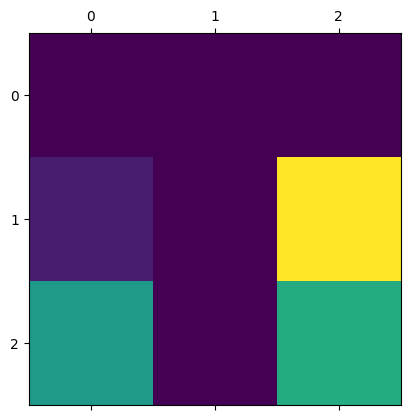

In [23]:
plt.matshow(heatmap[2, :, :])
plt.show()

In [18]:
resized_heatmap = get_resized_heatmap(heatmap, images.shape)

(250, 3, 3)
(250, 1, 112, 112)


In [27]:
if not os.path.exists('./plots'):
    os.mkdir(base_dir)
if not os.path.exists('./plots/GradCAM/'):
    os.mkdir('./plots/GradCAM')
if not os.path.exists('./plots/GradCAM/test/'):
    os.mkdir('./plots/GradCAM/test/')

for i in range(test_org[0]):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(2, 2))
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)

    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)


    # Assuming batch size is 1 for simplicity. If batch size > 1, you can change the index to visualize other samples.
    slice_idx = i  # The slice number you want to visualize
    image = images[slice_idx]
    image = image.squeeze(0)

    # Display the original slice on the left
    ax[0].imshow(image, cmap='bone')

    # Display the original slice on the right
    img0 = ax[1].imshow(image, cmap='bone')

    # Overlay the heatmap on the right image
    img1 = ax[1].imshow(resized_heatmap[slice_idx, :, :], cmap='jet', alpha=0.4, extent=img0.get_extent())

    plt.tight_layout()
    plt.savefig(f'./plots/GradCAM/test/gradcam_test_img{i}.png', dpi=300, bbox_inches='tight', format='png')
    #plt.show()
    plt.close()